### This first part of the code will pull the all businesses in certain categories in San Francisco and calculate their standardized score based on (a) sum of z-score from rating and number of tips (b) number of tips only.

In [35]:
# Insert needed dependencies - this may change later

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.19.0                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Folium installed
Libraries imported.


# Foursquare API's search only returns 50 results. Next step, I'll have to iterate through a grid to FIND the places.

In [262]:
# Define Foursquare credentials
CLIENT_ID = 'ZYL5XURS4D3UI0KJGZUUE4DJ4CVHNWSILAWJ4CDWRJLHRQDF' # your Foursquare ID
CLIENT_SECRET = 'VS4UKO223O205C1YIWCWTSFB0CJTRK5XK0QAVNGPUV1UZTTL' # your Foursquare Secret
VERSION = '20180604'

# let's define a minimum and maximum latitude and longitude and all points in between.

# These are numbers from https://boundingbox.klokantech.com/ - let's hope they are good enough...

latitude_minimum = 37.729848486
latitude_maximum = 37.8058394234
longitude_maximum = -122.380359918
longitude_minimum = -122.5053294005
number_of_points = 7 # We'll be iterating through the square of this number of points.

latitude_list = np.linspace(latitude_minimum,latitude_maximum,number_of_points)
longitude_list = np.linspace(longitude_minimum,longitude_maximum,number_of_points)

search_term = 'Sandwich'
rad = 500

#Loop begins here

#set up the empty dataframe that will get appended

df = pd.DataFrame(columns= ['name','id', 'location.lat','location.lng'])

for i in range(0,(len(latitude_list))):
    for j in range(0,(len(longitude_list))):
        lattemp = latitude_list[i]
        longtemp = longitude_list[j]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, lattemp, longtemp ,VERSION, rad, search_term)
        results = requests.get(url).json()
        venues = results['response']['venues'] # Get the JSON into a dataframe
        dataframe = json_normalize(venues)  # transform venues into a dataframe
        size = dataframe.shape
        if size[1] == 0: continue
        filtered_columns = ['name', 'id','location.lat','location.lng']
        dataframe_filtered = dataframe.loc[:,filtered_columns]
        df = df.append(dataframe_filtered, ignore_index=True)
    


In [263]:
#Remove duplicates

df.drop_duplicates(keep=False, inplace=True)
print(df.shape)
print(df)

(31, 4)
                                        name                        id  \
0             El Ahorro Market Sandwich Shop  592b28a8d1a4025588376af3   
1                    constanso' s sandwiches  50785b20498e98df0e1248d0   
2     Central Haight Coffee Tea & Sandwiches  4bbb548e935e952100082990   
3                         The Sandwich Place  43fa004df964a520d72f1fe3   
4                     margie's beef sandwich  4f2f36ffe4b047964b31f262   
5                        Two Sons Sandwiches  50787024e4b0e94246b955aa   
6                          avenue sandwiches  50ec7f3d45b04b17df1c2efd   
7                  Mai Mai Sandwich & Bakery  5b9844648c812a002ce038db   
8                Allstar Donuts and Sandwich  4f32580519836c91c7ce77bc   
9                       Jefe's PB&J Sandwich  4c0ed04575f99c746487ecc4   
10               Ka Ka Vietnamese Sandwiches  4e1a035eae6092c2766126af   
11                           Saigon Sandwich  43eb7d31f964a520392f1fe3   
12                   L&G Vietn

## Next use the venue IDs  to pull the tips and ratings

In [264]:
# Extract a vector of venue IDs only

venue_ids = df.loc[:,'id']
venue_ids.loc[venue_ids.index[1]]

id_df = pd.DataFrame(columns=['id', 'rating','tips'])

for i in range(0,(len(venue_ids.index))):
    vid = venue_ids.loc[venue_ids.index[i]]
    id_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format( vid,CLIENT_ID, CLIENT_SECRET, VERSION)
    id_results = requests.get(id_url).json()
    try:
        id_rating = id_results['response']['venue']
    except:
        continue
    try:
        venue_rating = id_rating['rating']
    except:
        venue_rating = 0
    try:
        venue_tips = id_rating['stats']['tipCount']
    except:
        venue_tips = 0  
    d = {'id': [vid], 'rating': [venue_rating], 'tips': [venue_tips],}
    id_dataframe_filtered = pd.DataFrame(data=d)
    print(id_dataframe_filtered)
    id_df = id_df.append(id_dataframe_filtered, ignore_index=True)
 
    

                         id  rating  tips
0  592b28a8d1a4025588376af3       0     0
                         id  rating  tips
0  50785b20498e98df0e1248d0       0     0
                         id  rating  tips
0  4bbb548e935e952100082990     7.3     2
                         id  rating  tips
0  43fa004df964a520d72f1fe3     8.7    22
                         id  rating  tips
0  4f2f36ffe4b047964b31f262       0     1
                         id  rating  tips
0  50787024e4b0e94246b955aa     8.9    12
                         id  rating  tips
0  50ec7f3d45b04b17df1c2efd       0     0
                         id  rating  tips
0  5b9844648c812a002ce038db       0     0
                         id  rating  tips
0  4f32580519836c91c7ce77bc       0     0
                         id  rating  tips
0  4c0ed04575f99c746487ecc4       0     2
                         id  rating  tips
0  4e1a035eae6092c2766126af       0     1
                         id  rating  tips
0  43eb7d31f964a520392f1fe3     9.

In [265]:
#Merge the two steps together

df_merged = df.merge(id_df, left_on='id', right_on='id')

Exploratory Data Analysis

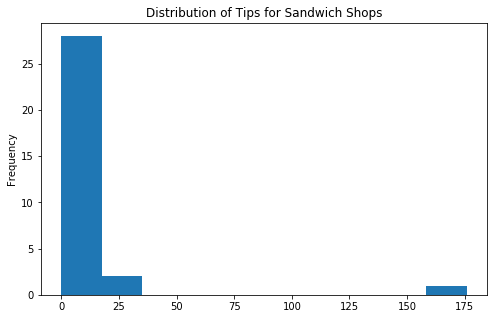

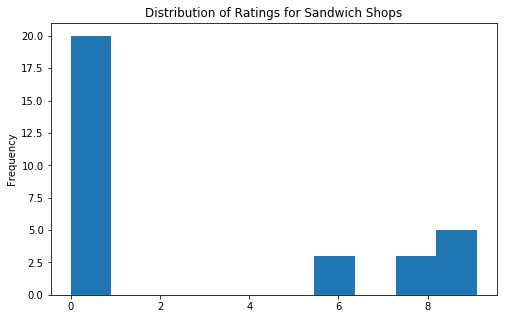

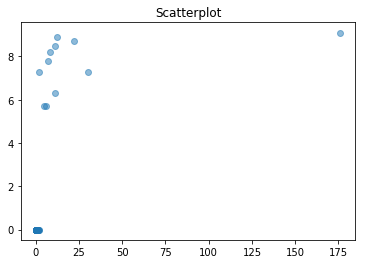

,name,id,location.lat,location.lng,rating,tips,zscore_tips,zscore_ratings,composite_score
4,Sing Sing Sandwich Shop,4b53a444f964a520e5a527e3,37.783771,-122.415972,6.3,11,0.0455579,0.97473,1.02029
9,Ike's Love & Sandwiches,5914e8fae1f0aa603aa3c369,37.785146,-122.419629,8.2,8,-0.050735,1.48825,1.43751
10,Saigon Sandwich,43eb7d31f964a520392f1fe3,37.783084,-122.417650,9.1,176,5.34167,1.7315,7.07316
11,The Sandwich Place,43fa004df964a520d72f1fe3,37.764321,-122.419494,8.7,22,0.398632,1.62339,2.02202
12,Lee's Sandwiches,4a6f6f5cf964a52029d61fe3,37.783714,-122.417684,7.3,30,0.655413,1.245,1.90042
13,Two Sons Sandwiches,50787024e4b0e94246b955aa,37.764541,-122.406355,8.9,12,0.0776556,1.67744,1.7551
14,Mendocino Farms,5b6c8b982db4a9002c2a57dc,37.792850,-122.402363,8.5,11,0.0455579,1.56933,1.61489


In [430]:
# Insert Code here
#Import seaborn, matplotlib

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

#Distributions, histograms


#Distribution of number of tips

df_merged['tips'].plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of Tips for Sandwich Shops') # add a title to the histogram

plt.show()

# Distribution of ratings

df_merged['rating'].plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of Ratings for Sandwich Shops') # add a title to the histogram

plt.show()

#Correlations - create a scatterplot

plt.scatter(number_of_tips, average_rating, alpha=0.5)
plt.title('Scatterplot')
plt.show()

#First let's get the 5 venues with the most tips

sorted_by_tips = df_merged.sort_values(by=['tips'], ascending=False)
top_tips = sorted_by_tips.head()

#Then, the 5 venues with the highest number of ratings

sorted_by_ratings = df_merged.sort_values(by=['rating'], ascending=False)
top_ratings = sorted_by_ratings.head()

#Standardize variables (zero mean, unit standard deviation)

df_merged.loc[:,'zscore_tips'] = (df_merged.loc[:,'tips'] - df_merged.loc[:,'tips'].mean())/df_merged.loc[:,'tips'].std(ddof=0)
df_merged.loc[:,'zscore_ratings'] = (df_merged.loc[:,'rating'] - df_merged.loc[:,'rating'].mean())/df_merged.loc[:,'rating'].std(ddof=0)
df_merged.loc[:,'composite_score'] = df_merged.loc[:,'zscore_tips']+df_merged.loc[:,'zscore_ratings']

sorted_by_composite = df_merged.sort_values(by=['composite_score'], ascending=False)
top_composite = sorted_by_composite.head()

#Generate a unified list of top places

top_places = pd.concat([top_tips, top_ratings, top_composite], ignore_index=True)
top_places_unique = top_places.drop_duplicates(subset=['location.lat','location.lng','name'],keep="last")

top_places_unique

In [432]:
#Visualize the top sandwich places

sf_latitude = 37.77
sf_longitude = -122.42

sf_map = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=13)

# instantiate a feature group for the incidents in the dataframe
sandwich_places = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(top_places_unique.loc[:,'location.lat'], top_places_unique.loc[:,'location.lng']):
    sandwich_places.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
# add sandwich places to map
sf_map.add_child(sandwich_places)
sf_map





### The second part of the code will identify characteristics of these businesses in terms of their immediate neighborhood.###

In [283]:
# Define the function that will get the details of neighboring venues
def getNearbyVenues(names, ids, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, iden, lat, lng in zip(names, ids, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            iden,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location Name',
                  'Id',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [367]:
# we'll use the Foursquare explore function
# take the dataframe of latitudes and longitudes for the places of interest
# set up the loop
limit = 100

neighboring_venues = getNearbyVenues(names=top_places_unique['name'],
                                     ids = top_places_unique['id'],
                                   latitudes=top_places_unique['location.lat'],
                                   longitudes=top_places_unique['location.lng']
                                  )

Sing Sing Sandwich Shop
Ike's Love & Sandwiches
Saigon Sandwich
The Sandwich Place
Lee's Sandwiches
Two Sons Sandwiches
Mendocino Farms


In [368]:
# one hot encoding
venue_dummies = pd.get_dummies(neighboring_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venue_dummies['Location Name'] = neighboring_venues['Location Name'] 
venue_dummies['Latitude'] = neighboring_venues['Latitude'] 
venue_dummies['Longitude'] = neighboring_venues['Longitude'] 
venue_dummies['Id'] = neighboring_venues['Id'] 

venues_grouped = venue_dummies.groupby('Id').mean().reset_index()
venues_grouped


,Id,Adult Boutique,Afghan Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,...,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Latitude,Longitude
0,43eb7d31f964a520392f1fe3,0.00,0.01,0.02,0.00,0.000000,0.01,0.01,0.01,0.000000,...,0.01,0.00,0.02,0.08,0.00,0.01,0.00,0.000000,37.783084,-122.417650
1,43fa004df964a520d72f1fe3,0.01,0.00,0.00,0.01,0.030000,0.00,0.00,0.01,0.000000,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.020000,37.764321,-122.419494
2,4a6f6f5cf964a52029d61fe3,0.00,0.01,0.02,0.00,0.010000,0.01,0.01,0.01,0.000000,...,0.01,0.01,0.02,0.08,0.00,0.02,0.00,0.000000,37.783714,-122.417684
3,4b53a444f964a520e5a527e3,0.00,0.01,0.02,0.00,0.010000,0.01,0.00,0.00,0.000000,...,0.01,0.01,0.02,0.08,0.00,0.02,0.00,0.000000,37.783771,-122.415972
4,50787024e4b0e94246b955aa,0.00,0.00,0.00,0.00,0.096154,0.00,0.00,0.00,0.019231,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.019231,37.764541,-122.406355
5,5914e8fae1f0aa603aa3c369,0.00,0.01,0.01,0.00,0.010000,0.00,0.00,0.01,0.000000,...,0.01,0.01,0.02,0.07,0.00,0.01,0.03,0.010000,37.785146,-122.419629
6,5b6c8b982db4a9002c2a57dc,0.00,0.00,0.01,0.00,0.000000,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.01,0.01,0.02,0.01,0.010000,37.792850,-122.402363


### The third part will put two and two together: (1) Create a grid of San Francisco and (2) Iterate through the grid-points and identify the spots that are most similar to the characteristics of the successful businesses as identified in the second part.

In [370]:
# Set up the grid of San Francisco - we already get it up above

latitude_minimum = 37.729848486
latitude_maximum = 37.8058394234
longitude_maximum = -122.380359918
longitude_minimum = -122.5053294005

#Let's try a different linspace accounting for the fact that San Francisco's length and width are different

base_points = 2
latitude_points = base_points * round((latitude_maximum-latitude_minimum)*100)
longitude_points = base_points * round((longitude_maximum-longitude_minimum)*100)

latitude_list = np.linspace(latitude_minimum,latitude_maximum,latitude_points)
longitude_list = np.linspace(longitude_minimum,longitude_maximum,longitude_points)

In [371]:
# Iterate through the grid points in the same way as characterizing the neighborhood of top sandwich shops

# Ids are not that important at this point. Names are though, we want to be able to identify these points later. Let's create a dataframe and append it as we go.

df = pd.DataFrame(columns= ['name','id', 'location.lat','location.lng'])

counter = 0
for i in range(0,(len(latitude_list))):
    for j in range(0,(len(longitude_list))):
        templat = latitude_list[i]
        templong = longitude_list[j]
        new_data=pd.DataFrame({'name':[counter], 'id':[counter], 'location.lat':[templat], 'location.lng':[templong]})
        df = df.append(new_data, ignore_index = True)
        counter = counter+1



In [372]:
df.shape

(384, 4)

In [316]:
limit = 100

grid_venues = getNearbyVenues(names=df['name'],
                                     ids = df['id'],
                                   latitudes=df['location.lat'],
                                   longitudes=df['location.lng']
                                  )



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [318]:
#Process this dataset the same way as the neighboring venues' to the sandwich shops

# one hot encoding
grid_dummies = pd.get_dummies(grid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
grid_dummies['Location Name'] = grid_venues['Location Name'] 
grid_dummies['Latitude'] = grid_venues['Latitude'] 
grid_dummies['Longitude'] = grid_venues['Longitude'] 
grid_dummies['Id'] = grid_venues['Id'] 

grid_grouped = grid_dummies.groupby('Id').mean().reset_index()


(370, 432)

In [449]:
#In this cell we merge together the sandwich shop data and the grid data

#We will only need the columns without latitude, longitude and ID from the sandwich shop data. Let's set up a list for that

varlist = list(venues_grouped)
varlist.remove('Id')
varlist.remove('Latitude')
varlist.remove('Longitude')


shop_final = venues_grouped.loc[:,varlist]
grid_final = grid_grouped.loc[:,varlist]

merged_data = pd.concat([shop_final,grid_final],ignore_index=True)

print(shop_final.shape)
print(grid_final.shape)
print(merged_data.shape)

# We will also need a final dataset just for visualization

varlist2 = ('Location Name','Latitude','Longitude','Id')

shop_viz = venues_grouped.loc[:,varlist2]
grid_viz = grid_grouped.loc[:,varlist2]

merged_viz = pd.concat([shop_viz,grid_viz],ignore_index=True)

merged_viz.head()


(7, 150)
(370, 150)
(377, 150)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:858: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


,Location Name,Latitude,Longitude,Id
0,NaN,37.783084,-122.417650,43eb7d31f964a520392f1fe3
1,NaN,37.764321,-122.419494,43fa004df964a520d72f1fe3
2,NaN,37.783714,-122.417684,4a6f6f5cf964a52029d61fe3
3,NaN,37.783771,-122.415972,4b53a444f964a520e5a527e3
4,NaN,37.764541,-122.406355,50787024e4b0e94246b955aa


In [450]:

import sklearn.cluster as sc
#Set up k-means clustering defining the latitude and longitude of some of the top places
#set number of clusters
#TRY A NUMBER OF KCLUSTERS BELOW

kclusters = 100

venues_grouped_clustering = merged_data

# run k-means clustering - CUSTOMIZE TO MAKE SURE RELEVANT POINTS ARE INCLUDED AS CENTROIDS    !!!
kmeans = sc.KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:377] 

array([10, 17, 10, 10, 14, 10, 33,  8,  8, 20, 20, 74, 57, 57,  5, 45, 18,
       44, 44, 12, 53, 73,  5,  5, 87,  9,  9, 48, 48, 19, 27,  8,  8, 20,
       20, 63, 51, 68, 84, 41,  2, 44,  6, 41, 50, 50, 99,  1, 11, 94, 67,
       21, 48,  2, 39,  1,  1, 32,  3, 92, 24, 84, 53, 50, 60, 60,  5, 12,
       41, 53, 53, 50, 50, 38, 38, 61, 86, 86, 65,  1, 32, 32,  3, 92, 24,
       24, 91, 26, 13, 58,  2,  2, 66, 90, 53, 17,  2, 93, 95, 25, 98, 96,
       24, 83, 83,  5, 37, 92, 54,  2, 12, 51, 51,  5,  5, 89, 50, 50, 50,
       50, 17, 23,  2, 82, 55, 55, 75, 83, 83, 37, 37, 54, 54, 24, 12, 15,
        2, 15,  5, 12, 50, 53, 17, 17, 17, 23,  2, 46, 49, 49, 79, 17, 17,
        7,  7, 59, 59, 85, 78, 78, 96, 70, 70, 77, 77, 77, 17, 17, 89, 89,
       78, 89, 49, 49, 30,  5,  2, 12, 72, 59, 59, 85, 78, 78,  8, 77, 53,
        2, 53,  1, 17, 17, 89, 14, 14, 89, 56, 56,  5, 80,  5, 12, 12, 12,
       12, 15, 15, 15,  2, 69, 69, 77,  1,  1,  1,  1, 13, 14, 42,  0,  0,
        0, 24, 40, 40, 88

In [451]:
# Insert the cluster labels into the raw datafile

merged_viz.insert(0, 'Cluster Labels', kmeans.labels_)

#We need to standardize cluster numbers so that the first few clusters have the lowest numbers. In the seismic color scheme that would make them dark blue.

#Get the cluster labels associated with the sandwich shops

relevant_labels = merged_viz.loc[0:shop_final.shape[0],'Cluster Labels']
relevant_labels = relevant_labels.unique()

begin = shop_final.shape[0]+1
end = merged_viz.shape[0]

for i in range(begin,end):
        if merged_viz.loc[i,'Cluster Labels'] in relevant_labels: merged_viz.loc[i,'Cluster Labels'] = 0
        else: merged_viz.loc[i,'Cluster Labels'] = merged_viz.loc[i,'Cluster Labels'] + 50

merged_viz.loc[0:shop_final.shape[0],'Cluster Labels'] = 0           



In [452]:
#Now let's plot the grid. First let's just plot all points and then elaborate
import matplotlib.cm as cm
import matplotlib.colors as colors

sf_latitude = 37.77
sf_longitude = -122.42

sf_map = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=13)

kclusters = kclusters+50

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
seismic = [colors.rgb2hex(i) for i in colors_array]

# instantiate a feature group for the incidents in the dataframe
sandwich_places = folium.map.FeatureGroup()

# loop through gridpoints and add each to the sandwich places feature group
markers_colors = []
for lat, lng, cluster in zip(merged_viz.loc[:,'Latitude'], merged_viz.loc[:,'Longitude'], merged_viz.loc[:,'Cluster Labels']):
    sandwich_places.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color=seismic[cluster-1],
            fill=True,
            fill_color=seismic[cluster-1],
            fill_opacity=0.6
        )
    )

# add sandwich places to map
sf_map.add_child(sandwich_places)
sf_map
